# HELPER MODULES

In [2]:
from sklearn.metrics import mean_squared_error,accuracy_score, roc_auc_score,f1_score,confusion_matrix,roc_curve
from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler,PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, KFold ,GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
seed=0

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor,CatBoostClassifier
from lightgbm import LGBMRegressor,LGBMClassifier
from xgboost import XGBRegressor,XGBClassifier

#pip install pandas-profiling
import pandas_profiling
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import os 

C:\Users\PC\AppData\Local\Temp\ipykernel_11376\1655117510.py:15: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


# DATA INGESTION

**VALIDATION**

In [ ]:
# Define the path to the directory containing the CSV files
path = r"D:\ZINDI\TABULAR\Fault Impact Analysis Towards Service-Oriented Network Operation & Maintenanceby ITU\ZINDI\train"

# List all files in the directory
file_list = os.listdir(path)

# Initialize an empty list to store all dataframes
all_dataframes_val = []

# Loop through each file in the directory
for filename in file_list:
    # Get the full file path using os.path.join()
    file_path = os.path.join(path, filename)

    # Check if the file has a .csv extension (case-insensitive)
    if filename.lower().endswith('.csv'):
        # Read the CSV file into a dataframe
        df_val = pd.read_csv(file_path)

        # Modify the "NE ID" column by appending the filename suffix
        df_val["NE ID"] = df_val["NE ID"] + "_" + filename.split("_")[1].replace(".csv", "").replace(" ", "")

        # Append the modified dataframe to the list
        all_dataframes_val.append(df_val)

# Print the total number of dataframes read
print("Total dataframes read:", len(all_dataframes_val))

# Concatenate all dataframes vertically along the rows
test = pd.concat(all_dataframes_val, axis=0)

# Sort the concatenated dataframe by "NE ID" and "endTime" columns
test = test.sort_values(by=["NE ID", "endTime"], ascending=True)

# Save the sorted dataframe to a CSV file
test.to_csv('test.csv', index=False)

# Read the saved CSV file into a new dataframe
test = pd.read_csv("test.csv")

# Convert the "endTime" column to datetime format
test['endTime'] = pd.to_datetime(test['endTime'])

# Print the shape (dimensions) of the dataframe and display the first few rows
print("Shape of the dataframe:", test.shape)
print("First few rows of the dataframe:")
print(test.head())

In [ ]:
path=r"D:\ZINDI\TABULAR\Fault Impact Analysis Towards Service-Oriented Network Operation & Maintenanceby ITU\ZINDI\train"
file_list = os.listdir(path)

all_dataframes_val = []
for filename in file_list:
    file_path = os.path.join(path, filename)  # Use os.path.join() to get the full file path
    if filename.lower().endswith('.csv'):
        df_val = pd.read_csv(file_path)
        #df_val=df_val.drop(columns=["Unnamed: 0"])
        df_val["NE ID"]=df_val["NE ID"]+"_"+filename.split("_")[1].replace(".csv", "").replace(" ", "")
        all_dataframes_val.append(df_val)

print(len(all_dataframes_val))

test= pd.concat(all_dataframes_val, axis=0)
test=test.sort_values(by=["NE ID","endTime"],ascending=True)
test.to_csv('test.csv',index=False)

test=pd.read_csv("test.csv")
test['endTime']=pd.to_datetime(test['endTime'])
print(test.shape)
test.head()

**TRAIN**

In [9]:
path=r"D:\ZINDI\TABULAR\Fault Impact Analysis Towards Service-Oriented Network Operation & Maintenanceby ITU\ZINDI\validation_clean"
file_list = os.listdir(path)

all_dataframes_train = []
for filename in file_list:
    file_path = os.path.join(path, filename)  # Use os.path.join() to get the full file path
    if filename.lower().endswith('.csv'): #and os.path.getsize(file_path) > 10 * 1024
        df_train = pd.read_csv(file_path) 
        df_train["NE ID"]=df_train["NE ID"]+"_"+filename.split("_")[1].replace(".csv", "").replace(" ", "")
        all_dataframes_train.append(df_train)

print(len(all_dataframes_train))

train= pd.concat(all_dataframes_train, axis=0)
train=train.sort_values(by=["NE ID","endTime"],ascending=True)
train.to_csv('train.csv',index=False)
train=pd.read_csv("train.csv")
train['endTime']=pd.to_datetime(train['endTime'])
print(train.shape)
train.tail(1000)[80:85]

1932
(175150, 12)


,Unnamed: 0,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation
174230,61,B0122-42_1,2023-02-11 14:00:00,99.786871,24.951,1.848434,11.370351,6.257546,6.137244,11.617219,0.0,0.0
174231,62,B0122-42_1,2023-02-11 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,616.0,1.0
174232,0,B0122-42_2,2023-02-11 16:00:00,99.639547,21.661,1.884200,11.526920,6.513272,6.465226,11.111716,0.0,0.0
174233,1,B0122-42_2,2023-02-11 17:00:00,99.722531,20.258,1.873669,10.944421,6.375459,6.037012,11.415589,0.0,0.0
174234,2,B0122-42_2,2023-02-11 18:00:00,99.554814,21.545,1.855563,11.000512,6.764638,7.475538,13.629633,0.0,0.0


**COMBINE TRAIN & TEST**

In [10]:
train["predict_rows"]=0
test["predict_rows"]=0

train["IStrain"]=1
test["IStrain"]=0

test.loc[test["fault_duration"] > 0, "predict_rows"] = 1

combined_df=pd.concat([train,test]) 
combined_df.sort_values(by=["NE ID","endTime"],inplace=True)
print(len(combined_df))
combined_df[combined_df["NE ID"]=="B0017-13_8"]

1084072


,Unnamed: 0,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,predict_rows,IStrain
37561,NaN,B0017-13_8,2023-02-17 05:00:00,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0.0,0.000000,0,0
37562,NaN,B0017-13_8,2023-02-17 06:00:00,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0.0,0.000000,0,0
37563,NaN,B0017-13_8,2023-02-17 07:00:00,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,0.0,0.000000,0,0
37564,NaN,B0017-13_8,2023-02-17 08:00:00,99.829787,36.649,2.542375,12.062139,7.125136,7.467310,2.897868,46.0,0.654162,1,0
37565,NaN,B0017-13_8,2023-02-17 09:00:00,99.860807,58.506,2.412703,12.039579,6.916188,7.704837,2.397028,57.0,0.654162,1,0
37566,NaN,B0017-13_8,2023-02-17 10:00:00,99.844781,50.280,2.428769,12.145683,7.321369,8.263317,3.663715,2938.0,0.654162,1,0
37567,NaN,B0017-13_8,2023-02-17 11:00:00,99.942639,46.411,2.510660,12.264153,7.599301,8.270461,5.753700,1089.0,0.654162,1,0
37568,NaN,B0017-13_8,2023-02-17 12:00:00,90.738391,60.956,2.461951,12.093170,7.612720,9.045568,6.245630,25.0,0.654162,1,0


**TARGET VARIABLE**

In [11]:
combined_df['data_roc']=combined_df.groupby('NE ID',group_keys=False)['data_rate'].apply(lambda x: x.pct_change())#.fillna(0))

def data_rate_change(group):
    group['data_rate_t+1_trend'] = group['data_roc'].apply(lambda x: 0 if x >= 0 else 1)
    return group

train_grouped = combined_df.groupby('NE ID', as_index=False, group_keys=False).apply(data_rate_change)

# Now you can drop the 'data_roc' column if you want
#train_grouped = train_grouped.drop(columns=['data_roc'])

# Merge back the data from the grouped DataFrames to the original DataFrames
combined_df = train_grouped.reset_index(drop=True)
combined_df[combined_df["NE ID"]=="B0017-13_8"]

,Unnamed: 0,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,predict_rows,IStrain,data_roc,data_rate_t+1_trend
37561,NaN,B0017-13_8,2023-02-17 05:00:00,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0.0,0.000000,0,0,NaN,1
37562,NaN,B0017-13_8,2023-02-17 06:00:00,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0.0,0.000000,0,0,-0.460840,1
37563,NaN,B0017-13_8,2023-02-17 07:00:00,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,0.0,0.000000,0,0,-0.825678,1
37564,NaN,B0017-13_8,2023-02-17 08:00:00,99.829787,36.649,2.542375,12.062139,7.125136,7.467310,2.897868,46.0,0.654162,1,0,-0.657071,1
37565,NaN,B0017-13_8,2023-02-17 09:00:00,99.860807,58.506,2.412703,12.039579,6.916188,7.704837,2.397028,57.0,0.654162,1,0,-0.172830,1
37566,NaN,B0017-13_8,2023-02-17 10:00:00,99.844781,50.280,2.428769,12.145683,7.321369,8.263317,3.663715,2938.0,0.654162,1,0,0.528440,0
37567,NaN,B0017-13_8,2023-02-17 11:00:00,99.942639,46.411,2.510660,12.264153,7.599301,8.270461,5.753700,1089.0,0.654162,1,0,0.570455,0
37568,NaN,B0017-13_8,2023-02-17 12:00:00,90.738391,60.956,2.461951,12.093170,7.612720,9.045568,6.245630,25.0,0.654162,1,0,0.085498,0


# DATA REDUCTION


**DROP IDS WITH DURATION GREATER THAN ONE IN ALL ROWS OF EACH ID**

In [12]:
print("Before:", len(combined_df))

# Group by 'NE ID'
grouped = combined_df.groupby('NE ID')

# Function to drop groups with more than one row with fault_duration > 0
def drop_groups(group):
    if (group['fault_duration'] > 0).sum() == len(group):
        return group.head(1)  # Keep only the first row
    else:
        pass  # Return an empty DataFrame to drop the group

# Apply the function to each group
filtered_groups = grouped.apply(drop_groups)

drop_cols=filtered_groups["NE ID"].unique().tolist()
combined_df=combined_df[~combined_df["NE ID"].isin(drop_cols)]
print("After:", len(combined_df)) 
combined_df[combined_df["NE ID"]=="B0017-13_8"]

Before: 1084072
After: 1080657


,Unnamed: 0,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,predict_rows,IStrain,data_roc,data_rate_t+1_trend
37561,NaN,B0017-13_8,2023-02-17 05:00:00,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0.0,0.000000,0,0,NaN,1
37562,NaN,B0017-13_8,2023-02-17 06:00:00,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0.0,0.000000,0,0,-0.460840,1
37563,NaN,B0017-13_8,2023-02-17 07:00:00,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,0.0,0.000000,0,0,-0.825678,1
37564,NaN,B0017-13_8,2023-02-17 08:00:00,99.829787,36.649,2.542375,12.062139,7.125136,7.467310,2.897868,46.0,0.654162,1,0,-0.657071,1
37565,NaN,B0017-13_8,2023-02-17 09:00:00,99.860807,58.506,2.412703,12.039579,6.916188,7.704837,2.397028,57.0,0.654162,1,0,-0.172830,1
37566,NaN,B0017-13_8,2023-02-17 10:00:00,99.844781,50.280,2.428769,12.145683,7.321369,8.263317,3.663715,2938.0,0.654162,1,0,0.528440,0
37567,NaN,B0017-13_8,2023-02-17 11:00:00,99.942639,46.411,2.510660,12.264153,7.599301,8.270461,5.753700,1089.0,0.654162,1,0,0.570455,0
37568,NaN,B0017-13_8,2023-02-17 12:00:00,90.738391,60.956,2.461951,12.093170,7.612720,9.045568,6.245630,25.0,0.654162,1,0,0.085498,0


**AVERAGE THE ROWS WITH DURATION >0 MANY TIMES INSTEAD OF DROPPING THE DATAFRAMES**

**ONLY PICK THE FIRST ROW OF DURATION>0**

In [13]:
print("Before:", len(combined_df))
# Group by 'NE ID'
grouped = combined_df.groupby('NE ID')

# Function to filter rows
def filter_rows(group):
    rows_with_fault_duration_zero = group[group['fault_duration'] == 0]
    first_fault_duration_gt_zero_index = group[group['fault_duration'] > 0].index[0]
    row_with_first_fault_duration_gt_zero = group.loc[first_fault_duration_gt_zero_index:first_fault_duration_gt_zero_index]
    return pd.concat([rows_with_fault_duration_zero, row_with_first_fault_duration_gt_zero])

# Apply the function to each group and reset index
combined_df = grouped.apply(filter_rows).reset_index(drop=True)
print("After:", len(combined_df))
combined_df[combined_df["NE ID"]=="B0017-13_8"]

Before: 1080657
After: 995512


,Unnamed: 0,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,predict_rows,IStrain,data_roc,data_rate_t+1_trend
35624,NaN,B0017-13_8,2023-02-17 05:00:00,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0.0,0.000000,0,0,NaN,1
35625,NaN,B0017-13_8,2023-02-17 06:00:00,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0.0,0.000000,0,0,-0.460840,1
35626,NaN,B0017-13_8,2023-02-17 07:00:00,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,0.0,0.000000,0,0,-0.825678,1
35627,NaN,B0017-13_8,2023-02-17 08:00:00,99.829787,36.649,2.542375,12.062139,7.125136,7.467310,2.897868,46.0,0.654162,1,0,-0.657071,1


**DROP ALL ROWS WITH 0 IN THE 'DATA_RATE' COLUMN AND 0 IN THE 'FAULT_DURATION' COLUMN**

In [14]:
print("Before:", len(combined_df))
combined_df = combined_df.loc[(combined_df['data_rate'] != 0) | (combined_df['fault_duration'] != 0)]
print("Before:", len(combined_df))
combined_df[combined_df["NE ID"]=="B0017-13_8"]

Before: 995512
Before: 957160


,Unnamed: 0,NE ID,endTime,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,relation,predict_rows,IStrain,data_roc,data_rate_t+1_trend
35624,NaN,B0017-13_8,2023-02-17 05:00:00,100.000000,1.054,3.035211,1.884315,10.792361,2.912705,89.909177,0.0,0.000000,0,0,NaN,1
35625,NaN,B0017-13_8,2023-02-17 06:00:00,100.000000,1.702,2.638554,5.715271,11.273952,9.487271,48.475408,0.0,0.000000,0,0,-0.460840,1
35626,NaN,B0017-13_8,2023-02-17 07:00:00,99.747899,14.521,2.963437,11.297409,8.910144,9.713915,8.450350,0.0,0.000000,0,0,-0.825678,1
35627,NaN,B0017-13_8,2023-02-17 08:00:00,99.829787,36.649,2.542375,12.062139,7.125136,7.467310,2.897868,46.0,0.654162,1,0,-0.657071,1


# VISUALIZE

**NULL VALS AND INCOSISTENT DFS**

In [15]:
print(combined_df.isnull().sum())
#combined_df.fillna(0,inplace=True)

Unnamed: 0                 787331
NE ID                           0
endTime                         0
access_success_rate         50335
resource_utilition_rate      2150
TA                           2796
bler                         2545
cqi                          2485
mcs                          2486
data_rate                    2905
fault_duration                  0
relation                        0
predict_rows                    0
IStrain                         0
data_roc                     9077
data_rate_t+1_trend             0
dtype: int64


**ADVERSERIAL VALIDATION**

In [16]:
y = combined_df['IStrain']
X = combined_df[[
 #'access_success_rate',
 'resource_utilition_rate',
 #'TA',
 'bler',
 'cqi',
 'mcs',
 'data_rate',
 'fault_duration',
 'relation',
]]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed)

model = LGBMClassifier(random_state=seed) 
model.fit(X_train, y_train)
# Predict the probabilities of being in the train set for the validation data
valid_pred_proba = model.predict_proba(X_valid)[:, 1]

# Calculate the ROC-AUC score for adversarial validation
roc_auc = roc_auc_score(y_valid, valid_pred_proba)
print("Adversarial Validation ROC-AUC Score:", roc_auc)

Adversarial Validation ROC-AUC Score: 0.636560047891134


Top 10 Features:
cqi
resource_utilition_rate
bler
data_rate
mcs
fault_duration
relation
Adversarial Validation ROC-AUC Score: 0.6369848479359598


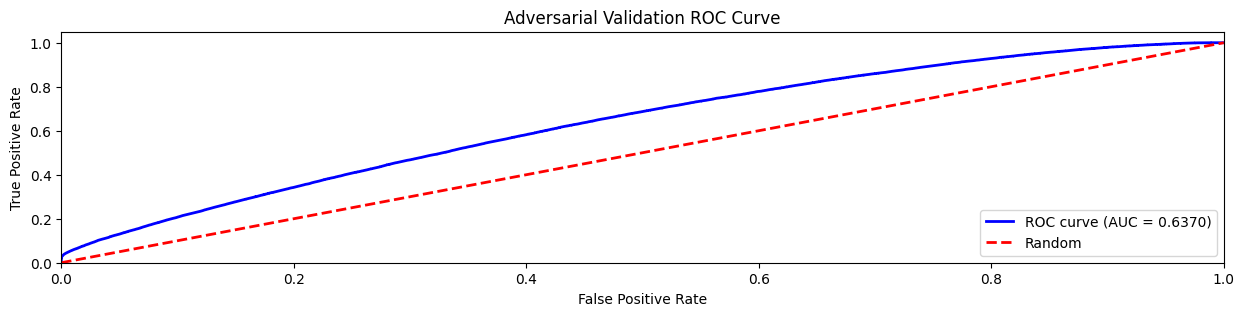

In [17]:
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
feature_importances = model.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
top_10_features = sorted_indices[:10]
print("Top 10 Features:")
for feature_index in top_10_features:
    print(X_train.columns[feature_index])
    pass

#Predict the probabilities of being in the train set for the validation data
valid_pred_proba = model.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, valid_pred_proba)
print("Adversarial Validation ROC-AUC Score:", roc_auc)
fpr, tpr, _ = roc_curve(y_valid, valid_pred_proba)

#Plot the ROC curve
plt.figure(figsize=(15, 3))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adversarial Validation ROC Curve')
plt.legend(loc='lower right')

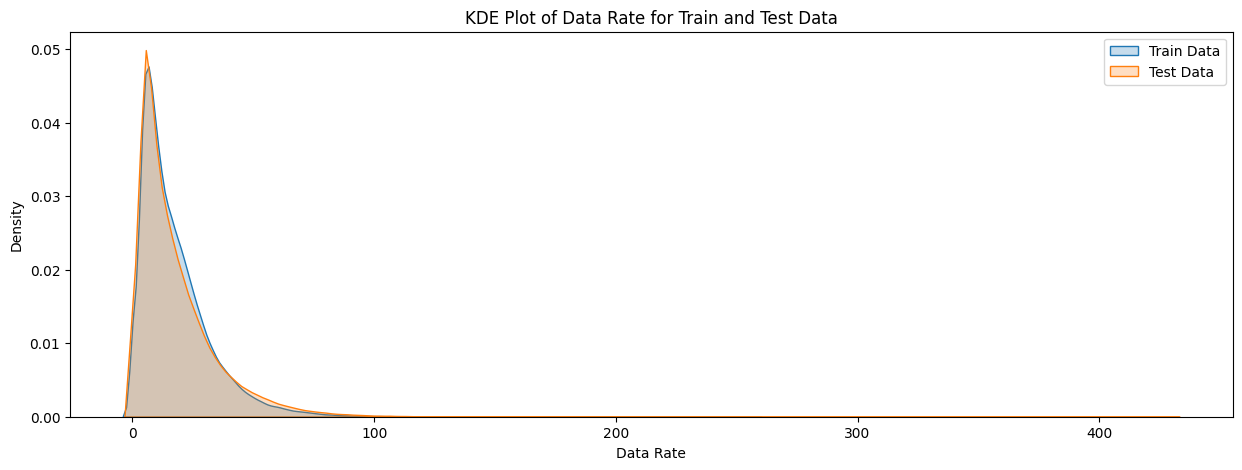

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have separate DataFrames for train and test datasets: train_df and test_df

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the KDE for the 'data_rate' feature in the train dataset
sns.kdeplot(train['data_rate'], label='Train Data', ax=ax, shade=True)

# Plot the KDE for the 'data_rate' feature in the test dataset
sns.kdeplot(test['data_rate'], label='Test Data', ax=ax, shade=True)

# Add labels and a legend
ax.set_xlabel('Data Rate')
ax.set_ylabel('Density')
plt.legend()

# Set the plot title
plt.title('KDE Plot of Data Rate for Train and Test Data')

# Show the plot
plt.show()

**BAR PLOTS-NUMERICAL**

In [19]:
numeric_cols=[]
categorical_cols=[]

for column in [col for col in train.columns.tolist() if col not in ["target"]]:
    if train[column].nunique()>30:
        numeric_cols.append(column)
    elif train[column].nunique()<30:
        categorical_cols.append(column)
categorical_cols

['predict_rows', 'IStrain']

ValueError: Could not interpret value `Unnamed: 0` for parameter `x`

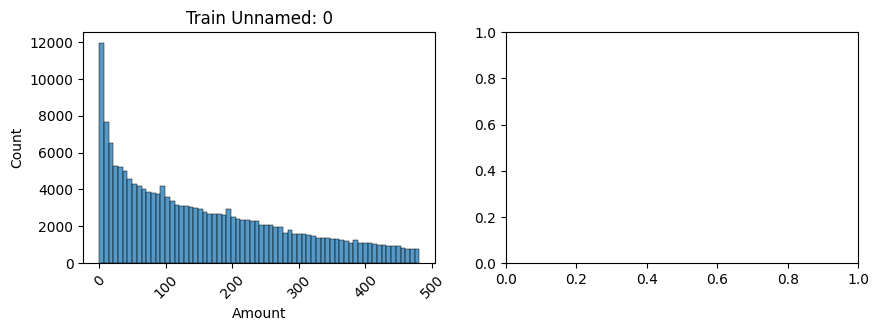

In [20]:
for column in numeric_cols:
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)  # Create a subplot for train data
    #plt.hist(train[column])
    sns.histplot(train, x=column) 
    plt.title(f"Train {column}")
    plt.xlabel("Amount")
    plt.ylabel("Count")
    plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
    
    plt.subplot(1, 2, 2)  # Create a subplot for test data
    #plt.hist(test[column])
    sns.histplot(test, x=column) 
    plt.title(f"Test {column}")
    plt.xlabel("Amount")
    plt.ylabel("Count")
    plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

**BOX PLOTS**

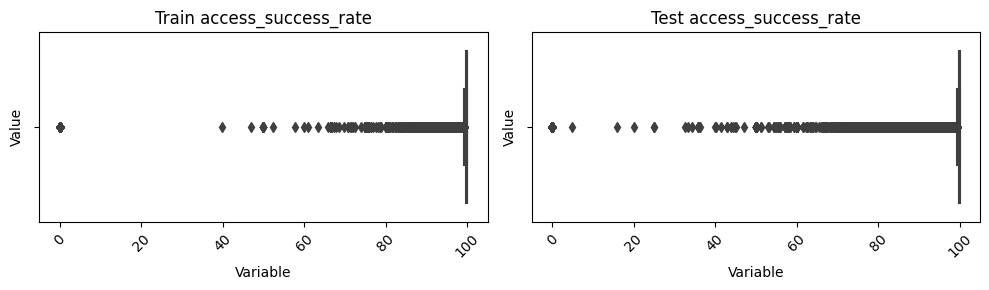

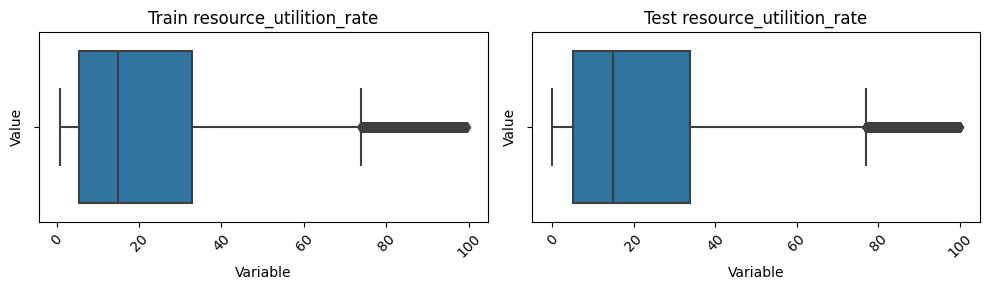

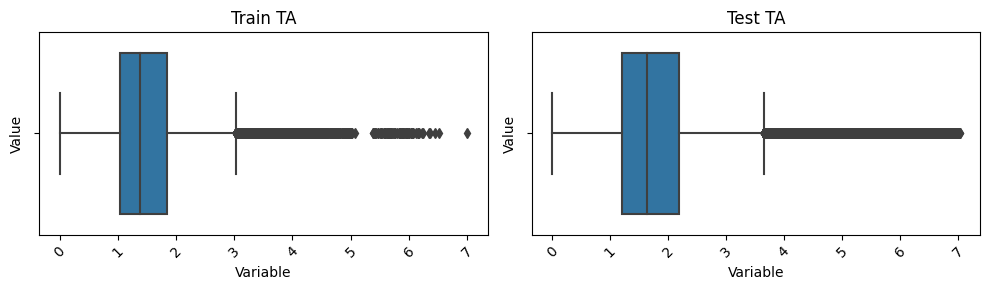

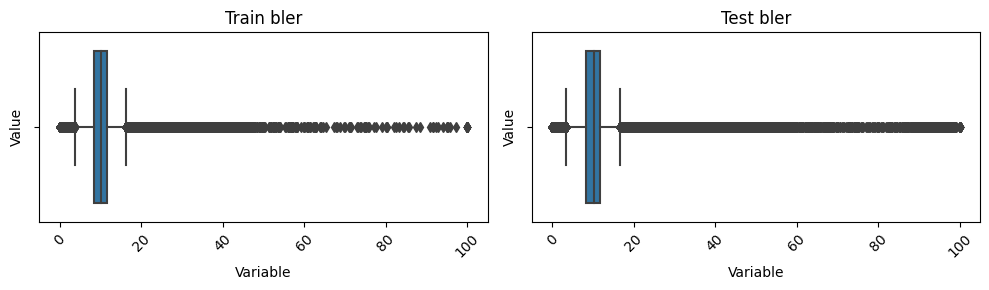

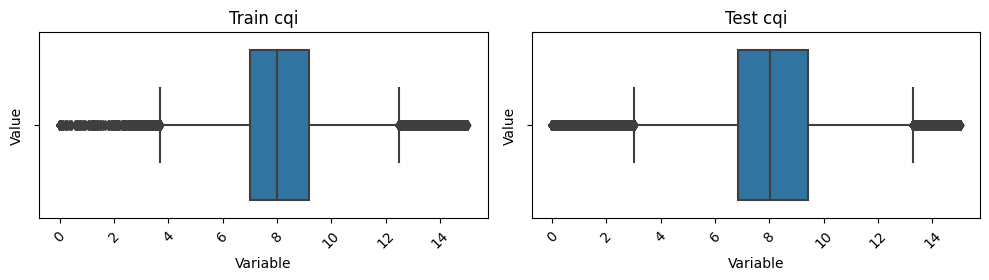

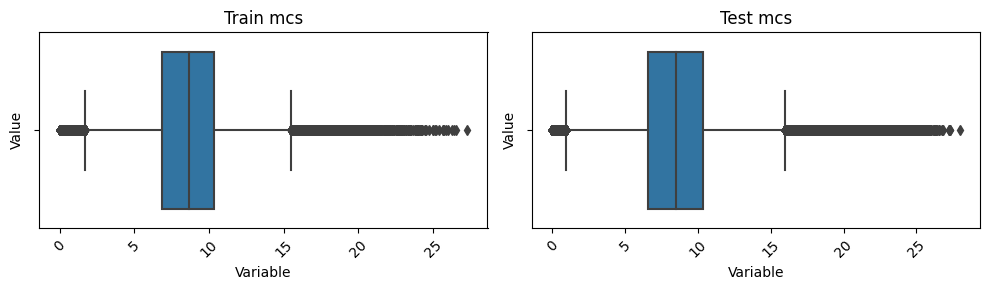

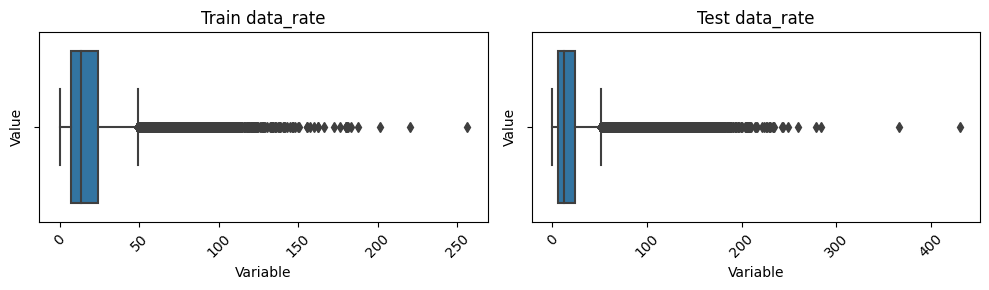

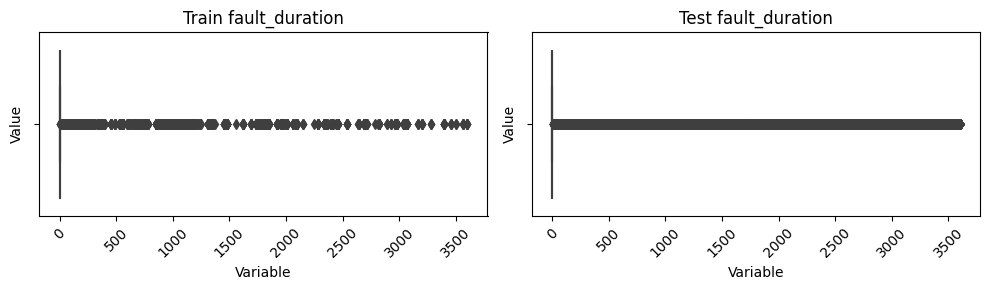

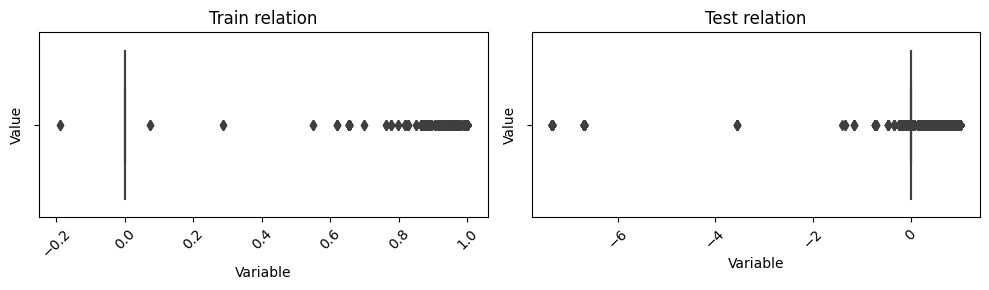

In [21]:
for column in numeric_cols:
    if train[column].dtype in [int, float]:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)  # Create a subplot for train data
        #plt.boxplot(x=train[column])
        sns.boxplot(x=train[column])
        plt.title(f"Train {column}")
        plt.xlabel("Variable")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees

        plt.subplot(1, 2, 2)  # Create a subplot for test data
        #plt.boxplot(test[column])
        sns.boxplot(x=test[column])
        plt.title(f"Test {column}")
        plt.xlabel("Variable")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees

        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()

**TIME FEATURES VIZES**

In [22]:
train["hour"] = train["endTime"].dt.hour
test["hour"] = test["endTime"].dt.hour
combined_df["hour"] = combined_df["endTime"].dt.hour

**VIOLIN PLOTS**

In [23]:
"""for column in numeric_cols:
    if train[column].dtype in [int, float]:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)  # Create a subplot for train data
        #plt.violinplot(train[column].values)
        sns.violinplot(x=train[column])
        plt.title(f"Train {column}")
        plt.xlabel("Variable")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees

        plt.subplot(1, 2, 2)  # Create a subplot for test data
        #plt.violinplot(test[column])
        sns.violinplot(x=test[column])
        plt.title(f"Test {column}")
        plt.xlabel("Variable")
        plt.ylabel("Value")
        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees

        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()"""

'for column in numeric_cols:\n    if train[column].dtype in [int, float]:\n        plt.figure(figsize=(10, 3))\n        plt.subplot(1, 2, 1)  # Create a subplot for train data\n        #plt.violinplot(train[column].values)\n        sns.violinplot(x=train[column])\n        plt.title(f"Train {column}")\n        plt.xlabel("Variable")\n        plt.ylabel("Value")\n        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees\n\n        plt.subplot(1, 2, 2)  # Create a subplot for test data\n        #plt.violinplot(test[column])\n        sns.violinplot(x=test[column])\n        plt.title(f"Test {column}")\n        plt.xlabel("Variable")\n        plt.ylabel("Value")\n        plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees\n\n        plt.tight_layout()  # Adjust spacing between subplots\n        plt.show()'

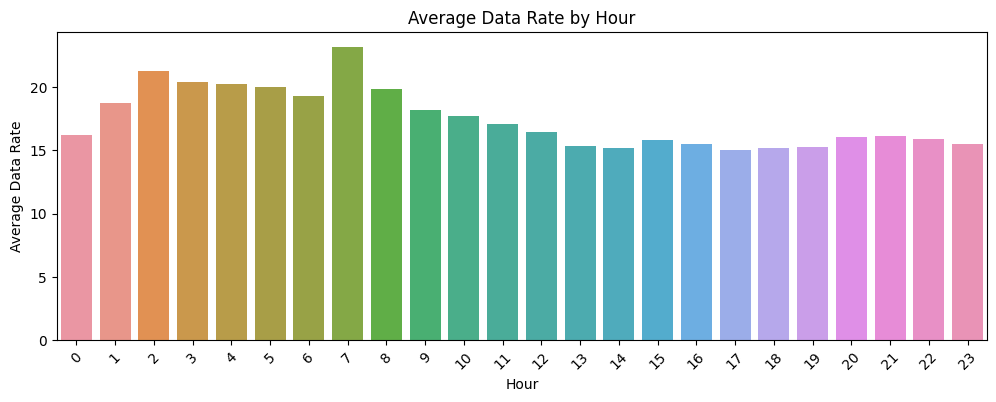

In [24]:
# Assuming you have a DataFrame named 'data' with columns 'hour' and 'data_rate'
hourly_mean = train.groupby("hour")["data_rate"].mean()

plt.figure(figsize=(12, 4))
sns.barplot(x=hourly_mean.index, y=hourly_mean.values)
plt.xlabel("Hour")
plt.ylabel("Average Data Rate")
plt.title("Average Data Rate by Hour")
plt.xticks(rotation=45)
plt.show()

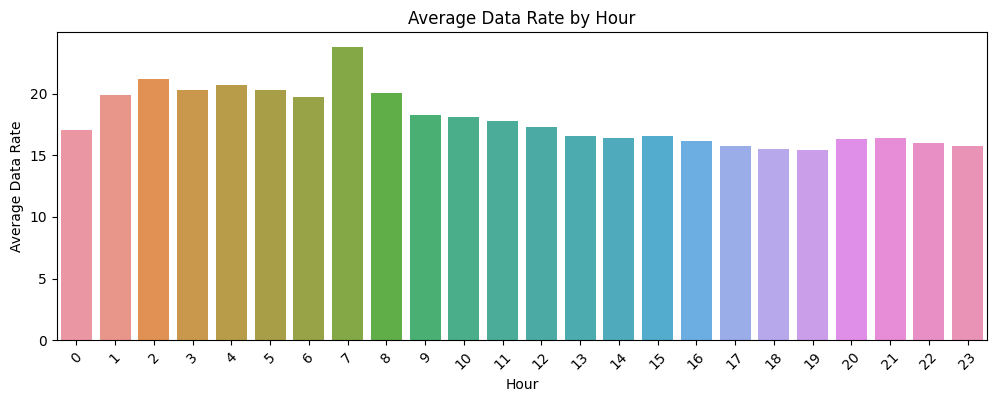

In [25]:
# Assuming you have a DataFrame named 'data' with columns 'hour' and 'data_rate'
hourly_mean = test.groupby("hour")["data_rate"].mean()

plt.figure(figsize=(12, 4))
sns.barplot(x=hourly_mean.index, y=hourly_mean.values)
plt.xlabel("Hour")
plt.ylabel("Average Data Rate")
plt.title("Average Data Rate by Hour")
plt.xticks(rotation=45)
plt.show()

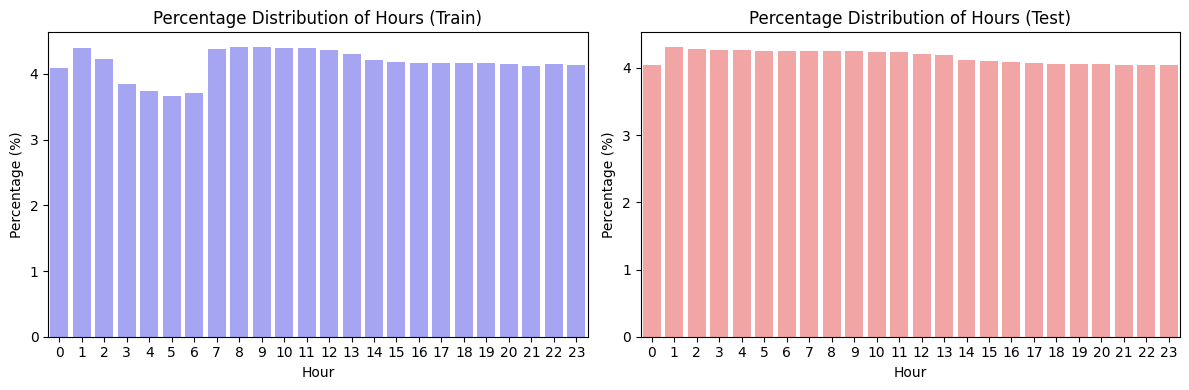

In [26]:
# Calculate the percentage distribution of values in the 'hour' column for combined_df and test
train_hour_percentage = (combined_df['hour'].value_counts() / len(combined_df)) * 100
test_hour_percentage = (test['hour'].value_counts() / len(test)) * 100

# Set up the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot combined_df data on the left subplot
sns.barplot(x=train_hour_percentage.index, y=train_hour_percentage.values, ax=axes[0], color='blue', alpha=0.4)
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Percentage Distribution of Hours (Train)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plot test data on the right subdata_rate_t+1_trendplot
sns.barplot(x=test_hour_percentage.index, y=test_hour_percentage.values, ax=axes[1], color='red', alpha=0.4)
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Percentage Distribution of Hours (Test)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

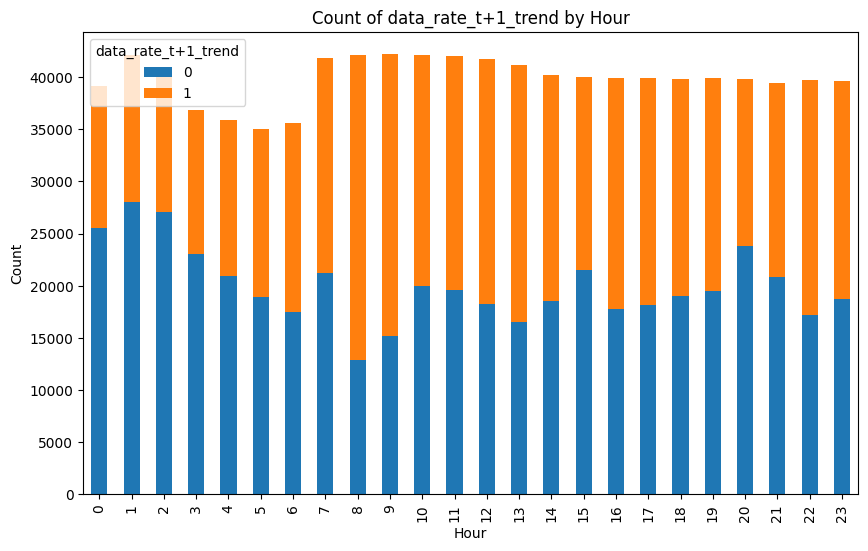

In [27]:
# Group by "hour" and "data_rate_t+1_trend", then count occurrences
count_df = combined_df.groupby(["hour", "data_rate_t+1_trend"]).size().reset_index(name="count")

# Pivot the table to make a categorical plot
pivot_df = count_df.pivot(index="hour", columns="data_rate_t+1_trend", values="count").fillna(0)

# Create a stacked bar plot
pivot_df.plot(kind="bar", stacked=True, figsize=(10, 6))

# Adding labels and title
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Count of data_rate_t+1_trend by Hour")

# Show the plot
plt.show()

**CORRELATION MATRIX**

C:\Users\PC\AppData\Local\Temp\ipykernel_22112\3464763650.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(test.drop(["predict_rows","IStrain","hour"],axis=1).corr(), annot=True, cmap='coolwarm', center=0)


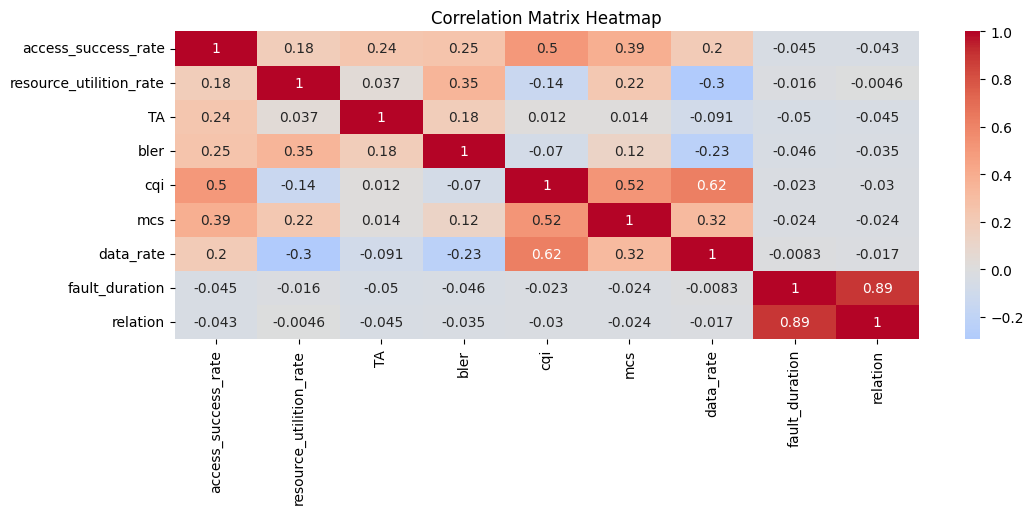

In [28]:
plt.figure(figsize=(12, 4))
sns.heatmap(test.drop(["predict_rows","IStrain","hour"],axis=1).corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_22112\3856160855.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, cmap='coolwarm', center=0)


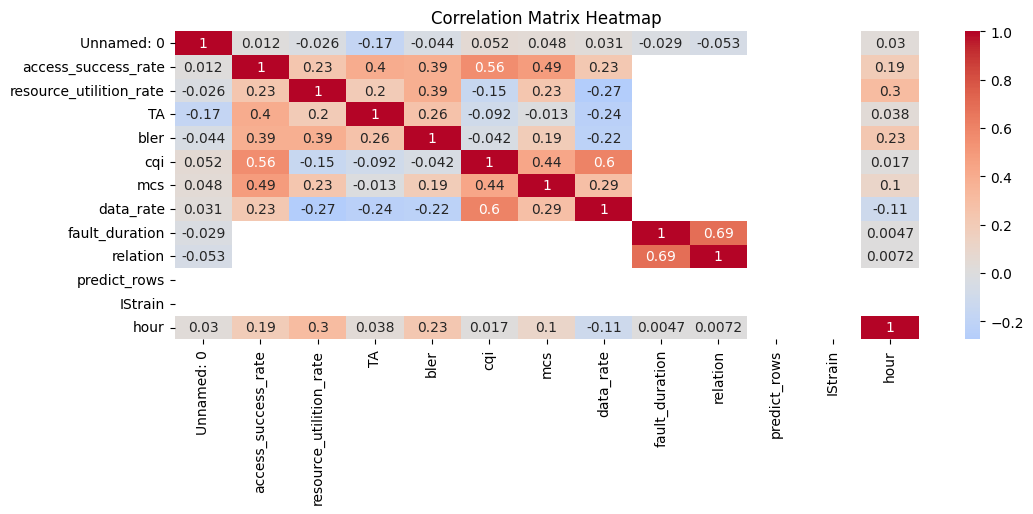

In [29]:
plt.figure(figsize=(12, 4))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

**HISTOGRAMS**

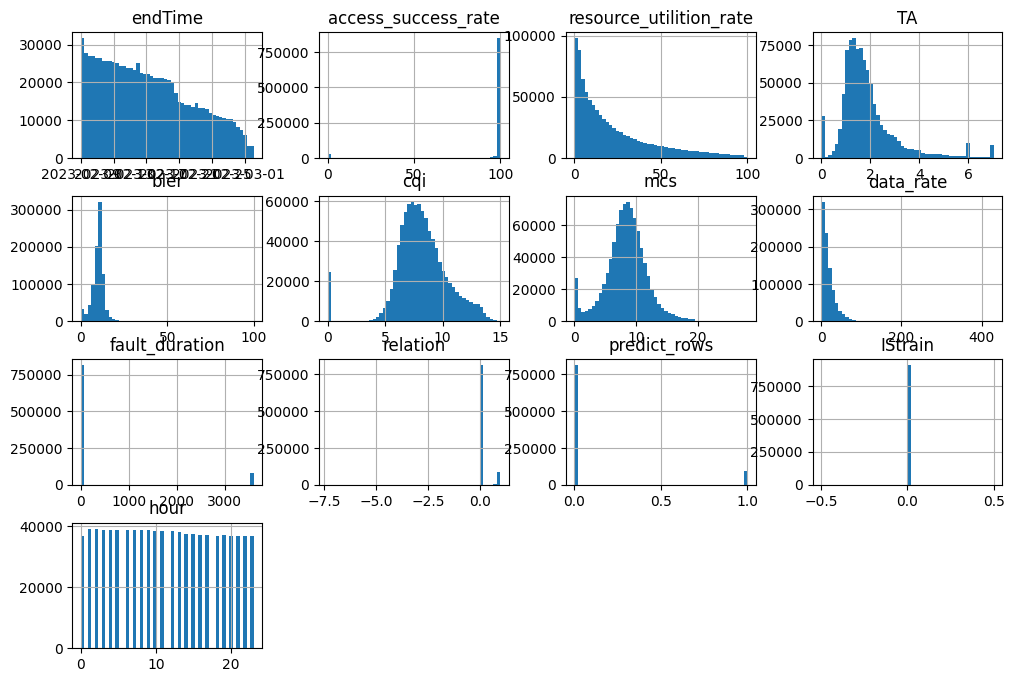

In [30]:
test.hist(bins=50, figsize=(12, 8))
plt.show()

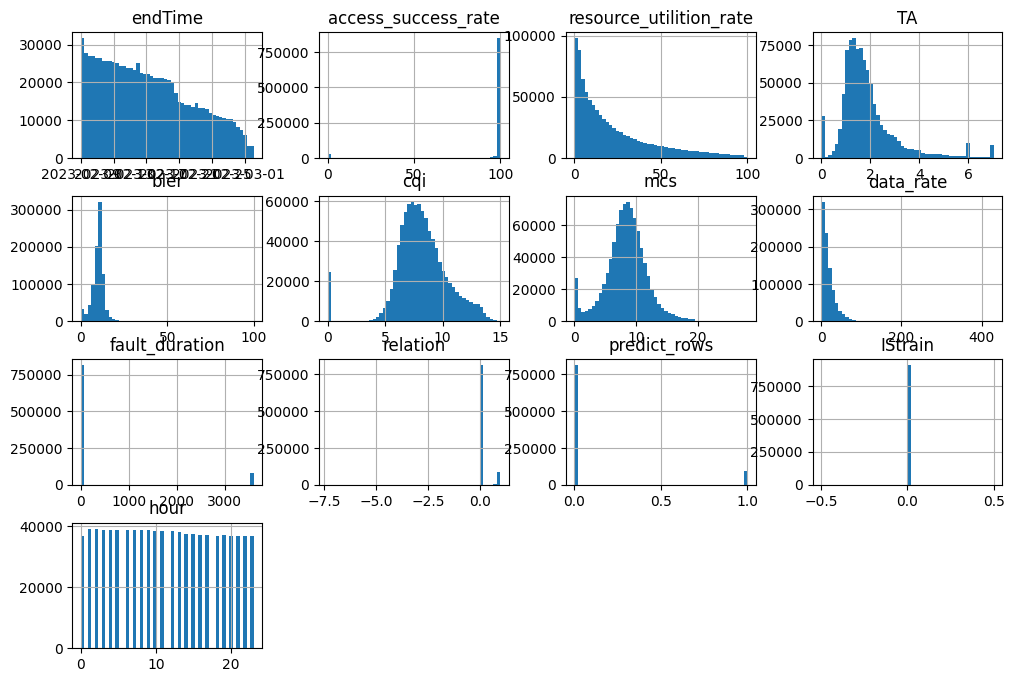

In [31]:
test.hist(bins=50, figsize=(12, 8))
plt.show()

**PAIR PLOTS**

In [32]:
#sns.pairplot(test, vars=test.columns.tolist()) #['Year of manufacture', 'Mileage', 'Engine Size']
#plt.show()

In [33]:
#sns.pairplot(train, vars=train.columns.tolist()) #['Year of manufacture', 'Mileage', 'Engine Size']
#plt.show()

**OVERALL VISUALISATION USING PANDAS PROFILING**

In [34]:
#profile = pandas_profiling.ProfileReport(combined_df)
# Save the report to an HTML file
#profile.to_file("combined_df_report2.html")
#profile